# Data Atelier - Prendre en main les méthodes d'explicabilités pour interpréter son modèle de machine learning !

Pour comprendre le fonctionnement des modèles de machine learning, il est proposé de comprendre un modèle appliqué au dataset en open data sur data.gouv : [Baromètre Représentations sociales du changement climatique - data.gouv.fr](https://www.data.gouv.fr/fr/datasets/barometre-representations-sociales-du-changement-climatique/)




### Pour une installation des dépendances à partir d'un environnement et d'un clone du repo
pip install -r requirements.dev.txt

### Pour une installation des dépendances sur google colab 
!pip install shapash>=2.3.7
!pip install pygwalker>=0.3.0
!pip install catboost>=1.2.0
!pip install lightgbm>=4.0.0


## Import des librairies

In [1]:
#Pour la manipulation de données
import pandas as pd
import numpy as np

#Pour la modélisation
from category_encoders import OrdinalEncoder
from sklearn.model_selection import train_test_split
import catboost
import lightgbm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn import metrics

#Pour l'analyse de données
import pygwalker as pyg

#Pour l'explicabilité
from shapash.explainer.smart_explainer import SmartExplainer
from shapash.explainer.consistency import Consistency
from sklearn.inspection import PartialDependenceDisplay
import shap


import warnings
warnings.filterwarnings("ignore")


In [2]:
#Pour afficher l'ensemble des colonnes et contenus des lignes
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)

## Import du dataset et cleaning

### Pour un chargement des données sur google colab
une des possibilités :
- Télécharger le fichier en local
- Puis l'importer dans google colab
```
from google.colab import files
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['OpinionWay_pour_ADEME_Barometre_changement_climatique_2000_2022.csv']),
                       delimiter=';',
                       encoding='Windows-1252')
```

In [3]:
df = pd.read_csv("../data/OpinionWay_pour_ADEME_Barometre_changement_climatique_2000_2022.csv", 
                       delimiter=';',
                       encoding='Windows-1252')

In [4]:
df.head(1)

,Vague,S1. genre,S2. âge,S3. Zone géo,Région,Département,S7. Taille commune,S7b. Taille commune,S7c. Taille commune,S6. Situation professionnelle,S5. CSP,q1_1. Enjeu important 1,q1_2. Enjeu important 2,q1_3. Enjeu important 3,q1total. Enjeu Emploi,q1total. Enjeu Sécurité,q1total. Enjeu Education et recherche,q1total. Enjeu Inégalités,q1total. Enjeu Logement,q1total. Enjeu Impôts et taxes,q1total. Enjeu Hausse des prix,q1total. Enjeu Immigration,q1total. Enjeu Environnement/Transition écologique,q1total. Enjeu Déficits publics,q1total. Enjeu Banlieues,q1total. Enjeu Transports,q1total. Enjeu Santé publique,q1total. Enjeu No rep.,q2_1. Problème environnemental 1,q2_2. Problème environnemental 2,q2total. Problème pollution de l'air,q2total. Problème pollution de l'eau,q2total. Problème bruit,q2total. Problème risques nucléaire,q2total. Problème déchets,q2total. Problème dégradation biodiversité,q2total. Problème Effet de serre/ réchauffement climatique,q2total. Problème dégradation des paysages,q2total. Problème aucun,q2total. Problème No rep.,q5. Certitude/hypothèse impact effet de serre,q8. Conséquences changement climatique,q8bis_1. Inquiétude conséquence 1,q8bis_2. Inquiétude conséquence 2,q8bis_total. Inquiétude catastrophe naturelle,q8bis_total. Inquiétude conflits entre Etats,q8bis_total. Inquiétude migrations population,q8bis_total. Inquiétude conflits politiques et sociaux,q8bis_total. Inquiétude développement maladies,q8bis_total. Inquiétude réchauffement températures,q8bis_total. aucun,q8bis_total. No rep.,q9. Causes désordres du climat,q10. Causes anthropiques/naturelles du changement climatique,q11. Solutions changement climatique,q12. Opportunité/ contrainte changement,q13_1. Conditions acceptation changement 1,q13_2. Conditions acceptation changement 2,q13total. Condition changements modérés,q13total. Condition compensation,q13total. Condition équité,q13total. Condition participation,q13total. Condition acceptation dans tous les cas,q13total. Condition No rep.,q14. Médiatisation changement climatique,q14b. Pourquoi souhaitez-vous qu'on en parle plus ?,q15_1. Acteur efficace 1,q15_2. Acteur efficace 2,q15total. instances internationales,q15total. Etats,q15total. collectivités locales,q15total. entreprises,q15total. associations,q15total. Chacun d'entre nous,q15total. Personne,q15total. No rep.,q15b_1. Acteur actif 1,q15b_2. Acteur actif 2,q15btotal. instances internationales,q15btotal. Etats,q15btotal. collectivités locales,q15btotal. entreprises,q15btotal. associations,q15btotal. Chacun d'entre nous,q15btotal. Personne,q15btotal. No rep.,q16. Optimisme limitation changement climatique,q18_i1. Causes GES activités industrielles,q18_i2. Causes GES transports,q18_i3. Causes GES bâtiments,q18_i4. Causes GES agriculture,"q18_i5. Causes GES centrales de production d'électricité au gaz, charbon ou fuel",q18_i6. Causes GES traitement des déchets,q18_i7. Causes GES destruction des forêts,q18_i8. Causes GES centrales nucléaires,q18_i9. Causes GES activité volcanique,q18_i10. Causes GES bombes aérosols,q18_i11. Causes GES numérique,q19_1. Action efficace réduction GES 1,q19_2. Action efficace réduction GES 2,q19total. Action efficace Achat voiture consommant moins,"q19total. Action efficace covoiturage, autopartage",q19total. Action efficace modes alternatifs voiture,q19total. Action efficace isolation logement,"q19total. Action efficace chauffage, chauffe-eau performant",q19total. Action efficace Appareils ménagers consommant moins,q19total. Action efficace EnR pour son logement,q19total. Action efficace consommer moins ou produits ayant moins d’impact,q19total. Action efficace réduire trier ses déchets,q19total. Action efficace télétravail,q19total. Action efficace No rep.,splitq20,q20_i1. Action individuelle Tri déchets,q20_i2. Actin individuelle Eteindre appareils en veille,q20_i3. Actin individuelle Transports en commun,q20_i4. Actin individuelle Baisse température logement,q20_i5. Actin individuelle Acheter légumes de s

### Création de variables

In [5]:
# création d'une variable sur une note moyenne des actions individuelles que le sondé est prêt à faire
notes_mapping = {
    '...vous le faites déjà': 4,
    '...vous pourriez le faire assez facilement': 3,
    '...vous pourriez le faire mais difficilement': 2,
    '...vous ne pouvez pas le faire': 1
}

def calculer_moyenne(row):
    notes = [notes_mapping[val] for val in row if val != 'No rep.']
    return sum(notes) / len(notes) if notes else 0

df_q20 = df.filter(like='q20', axis=1).replace({'nan': 'No rep.', np.nan: 'No rep.'})

colonnes_action_individuelle = df_q20.filter(like='q20').drop(columns=['splitq20'])

df_q20['moyenne_action_individuelle'] = colonnes_action_individuelle.apply(calculer_moyenne, axis=1)

df_q20['moyenne_action_individuelle'].round().value_counts()

moyenne_action_individuelle
3.0    13819
0.0     7407
4.0     4949
2.0     1589
1.0      104
Name: count, dtype: int64

In [6]:
# création d'une variable cible sur le taux de mesures que le sondé souhaite Très ou Assez souhaitable
notes_mapping = {
    'Très souhaitable': 4,
    'Assez souhaitable': 3,
    'Pas vraiment souhaitable': 2,
    'Pas du tout souhaitable': 1
}

# Filtrer les colonnes qui commencent par "q21"
q21_columns = [col for col in df.columns if col.startswith('q21')]

df_q21 = df.filter(like='q21', axis=1).replace({'nan': 'No rep.', np.nan: 'No rep.'})

# Initialiser une nouvelle colonne dans le DataFrame pour stocker les taux
df_q21['taux_mesures_souhaitable'] = 0.0

# Parcourir les lignes et calculer le taux pour chaque individu
for index, row in df_q21.iterrows():
    total_cols_answered = sum(row[col] != "No rep." for col in q21_columns)
    if total_cols_answered > 0:
        desirable_count = sum(row[col] in ['Très souhaitable', 'Assez souhaitable'] for col in q21_columns)
        rate = desirable_count / total_cols_answered
        df_q21.at[index, 'taux_mesures_souhaitable'] = rate

In [7]:
#ajout des 2 variables construites au dataframe initial
df = pd.concat([df, df_q20[['moyenne_action_individuelle']], df_q21[['taux_mesures_souhaitable']]], axis=1)

### Simplification du dataset

In [8]:
# Dictionnaire de renommage des colonnes pour avoir un nom plus simple et court
columns_to_rename = {'S1. genre' : 'genre',
                      'S2. âge' : 'tranche_age',
                      'S3. Zone géo' : 'zone_geo',
                      'Région' : 'region',
                      'Département' : 'departement',
                      'S7b. Taille commune' : 'taille_commune',
                      'S6. Situation professionnelle' : 'situation_pro',
                      'S5. CSP' : 'csp',
                      'q5. Certitude/hypothèse impact effet de serre' : 'impact_effet_de_serre',
                      'q9. Causes désordres du climat' : 'cause_desordre',
                      's11. Désordre climatique subi' : "changement_subi",
                      'q10. Causes anthropiques/naturelles du changement climatique' : 'cause_changement_climatique',
                      'q11. Solutions changement climatique' : 'solutions',
                      'q18_i1. Causes GES activités industrielles' : 'causes_ges_industries', 
                      'q18_i2. Causes GES transports' : 'causes_ges_transports',
                      'q18_i3. Causes GES bâtiments' : 'causes_ges_batiments',
                      'q18_i4. Causes GES agriculture' : 'causes_ges_agriculture',
                      "q18_i5. Causes GES centrales de production d'électricité au gaz, charbon ou fuel"  : 'causes_ges_energie',
                      'q18_i6. Causes GES traitement des déchets' : 'causes_ges_dechets',
                      'q18_i7. Causes GES destruction des forêts' : 'causes_ges_forets',
                      'q18_i8. Causes GES centrales nucléaires': 'causes_ges_nucleaires',
                      'q18_i9. Causes GES activité volcanique' : 'causes_ges_volcans',
                      'q18_i10. Causes GES bombes aérosols' : 'causes_ges_aerosols',
                      'q18_i11. Causes GES numérique' : 'causes_ges_numeriques',
                      's13. Nb membres foyer' :'nb_membres_foyer',
                      's15. Diplôme' :'diplome', 
                      's17. Type habitat' : 'type_habitat',
                      's18. Statut locataire/propriétaire' : 'locataire_proprietaire',
                      's22. Mode de transport' : 'mode_transport',
                      's23. Partis politiques' : 'partis_politiques', 
                      's24. Echiquier politique' : 'echiquier_politiques',
                      's25. Sympathie mouvements écologistes' : 'sympathie_ecologie',
                      'q23. Véracité scientifique' : 'veracite_scientifique',
                      'q14. Médiatisation changement climatique' : 'mediatisation',
                      'q8. Conséquences changement climatique' : 'futures_consequences',
                      'q16. Optimisme limitation changement climatique' : 'limitation_changement',
                      'q13total. Condition changements modérés' : 'changements_moderes',
                      "q15btotal. associations" : "associations_acteurs",
                      "q15total. collectivités locales" : "collectivites_acteurs",
                      'q21_i1. Mesures Baisse vitesse autoroute' : 'baisse_vitesse_autoroute',
                      'q21_i10. Mesures Favoriser véhicules peu polluants' : 'favoriser_mobilite_douce',
                      'q21_i11. Mesures Menu restauration collective' : 'mesure_restauration'
                      }

In [9]:
#renommage des colonnes du dict
df.rename(columns=columns_to_rename, inplace=True)

In [10]:
# Sélection de features à conserver pour le modèle
features = ['Vague',
            'genre',
            'tranche_age',
            #'zone_geo',
            'region',
            #'departement',
            'taille_commune',
            'situation_pro',
            #'csp',
            'impact_effet_de_serre',
            'cause_desordre',
            'cause_changement_climatique',
            'solutions',
            'causes_ges_industries', 
            'causes_ges_transports',
            'causes_ges_batiments',
            'causes_ges_agriculture',
            'causes_ges_energie',            
            'causes_ges_forets',
            'causes_ges_nucleaires',
            'causes_ges_volcans',
            'causes_ges_aerosols',
            #'causes_ges_numeriques',
            'nb_membres_foyer',
            'diplome', 
            'type_habitat',
            'locataire_proprietaire',
            'mode_transport',
            'echiquier_politiques', 
            'sympathie_ecologie',
            'changement_subi',
            'veracite_scientifique',
            'mediatisation',
            'futures_consequences',
            'limitation_changement',
            #'changements_moderes',
            #'associations_acteurs',
            #'collectivites_acteurs',
            'moyenne_action_individuelle',
            'taux_mesures_souhaitable',
                      ]

In [11]:
#suppressions des lignes avec trop de valeurs vides et la cible "solutions" non répondu
print(df.shape)
df_reduit = df[features].copy()
df_reduit['number_of_NaNs'] = df_reduit.isnull().sum(axis=1)
df_reduit = df_reduit[df_reduit["number_of_NaNs"]<8]                      
df_reduit = df_reduit[df_reduit["taux_mesures_souhaitable"] !=0]
print(df_reduit.shape)

(27868, 185)
(17331, 34)


In [12]:
#nous remplaçons les Nan pour les colonnes sélectionnées
df_reduit.fillna("No rep.", inplace=True)

### Renommage des modalités 
Nous renommons les modalités de certaines colonnes pour un meilleur affichage

In [13]:
df_reduit.loc[df_reduit['cause_changement_climatique'] == 'Le réchauffement de la planète est causé par les activités humaines', 'cause_changement_climatique'] = 'activites_humaines'
df_reduit.loc[df_reduit['cause_changement_climatique'] == "Il s'agit uniquement d'un phénomène naturel qui a toujours existé", 'cause_changement_climatique'] = 'phenomene_naturel'

df_reduit.loc[df_reduit['impact_effet_de_serre'] == '...ou bien une certitude pour la plupart des scientifiques ?', 'impact_effet_de_serre'] = 'certitude_scientifique'
df_reduit.loc[df_reduit['impact_effet_de_serre'] == "...une hypothèse sur laquelle les scientifiques ne sont pas tous d'accord ?", 'impact_effet_de_serre'] = 'hypothese_non_certaine'

df_reduit.loc[df_reduit['sympathie_ecologie'] == '...assez de sympathie ?', 'sympathie_ecologie'] = 'assez'
df_reduit.loc[df_reduit['sympathie_ecologie'] == "...peu de sympathie ?", 'sympathie_ecologie'] = 'peu'
df_reduit.loc[df_reduit['sympathie_ecologie'] == "...beaucoup de sympathie ?", 'sympathie_ecologie'] = 'beaucoup'
df_reduit.loc[df_reduit['sympathie_ecologie'] == "...pas de sympathie ?", 'sympathie_ecologie'] = 'pas'

df_reduit.loc[df_reduit['cause_desordre'] == 'Les désordres du climat et leurs conséquences (tels que les canicules, les tempêtes, les sécheresses et les inondati', 'cause_desordre'] = 'certitudes_causes'
df_reduit.loc[df_reduit['cause_desordre'] == "Aujourd'hui, personne ne peut dire avec certitude les vraies raisons des désordres du climat", 'cause_desordre'] = 'pas_certitude'

df_reduit.loc[df_reduit['veracite_scientifique'] == 'Les scientifiques qui étudient les évolutions du climat évaluent correctement les risques du changement climatique', 'veracite_scientifique'] = 'evalue_correctement'
df_reduit.loc[df_reduit['veracite_scientifique'] == "Les scientifiques qui étudient les évolutions du climat exagèrent les risques du changement climatique", 'veracite_scientifique'] = 'scientifique_exagere'

df_reduit.loc[df_reduit['solutions'] == 'Il faudra modifier de façon importante nos modes de vie pour limiter le changement climatique', 'solutions'] = 'changer'
df_reduit.loc[df_reduit['solutions'].str.contains("le changement climatique est inévitable") , 'solutions'] = 'inevitable'
df_reduit.loc[df_reduit['solutions'] == "C'est aux Etats de rechercher un accord au niveau mondial pour limiter le changement climatique", 'solutions'] = 'entre_etats'
df_reduit.loc[df_reduit['solutions'] == "Le progrès technique permettra de trouver des solutions pour limiter le changement climatique", 'solutions'] = 'progres'

### Proposition de l'outils Pygwalker pour analyser les distributions des données

In [14]:
#walker = pyg.walk(df_reduit, env="Jupyter")

## Modélisation

In [15]:
# y est la variable à prédire et X les variables explicatives
y = df_reduit["taux_mesures_souhaitable"]
X = df_reduit.drop(["taux_mesures_souhaitable","number_of_NaNs","Vague"], axis=1)

In [16]:
#Encodage des variables : conversion des variables catégorielles en numérique
features_cat = [e for e in features if e not in ("taux_mesures_souhaitable", "moyenne_action_individuelle", "Vague")]

encoder = OrdinalEncoder(
    cols=features_cat,
    handle_unknown='ignore',
    return_df=True).fit(X)

X=encoder.transform(X)

In [17]:
#Split train/test et modélisation
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, train_size=0.75, random_state=1
)

model = catboost.CatBoostRegressor(max_depth=5)
model.fit(Xtrain, ytrain, verbose=False)

In [18]:
#Evaluation des performances
prediction = model.predict(Xtest)

mean_squared_error(ytest, prediction)


0.04020960417082458

# Explicabilité

Dans cette section, nous allons pouvoir utiliser l'ensemble des méthodes présentées en cours

In [19]:
#accéder au nom des colonnes du dataframe
Xtest.columns

Index(['genre', 'tranche_age', 'region', 'taille_commune', 'situation_pro', 'impact_effet_de_serre', 'cause_desordre', 'cause_changement_climatique', 'solutions', 'causes_ges_industries', 'causes_ges_transports', 'causes_ges_batiments', 'causes_ges_agriculture', 'causes_ges_energie', 'causes_ges_forets', 'causes_ges_nucleaires', 'causes_ges_volcans', 'causes_ges_aerosols', 'nb_membres_foyer', 'diplome', 'type_habitat', 'locataire_proprietaire', 'mode_transport', 'echiquier_politiques', 'sympathie_ecologie', 'changement_subi', 'veracite_scientifique', 'mediatisation', 'futures_consequences', 'limitation_changement', 'moyenne_action_individuelle'], dtype='object')

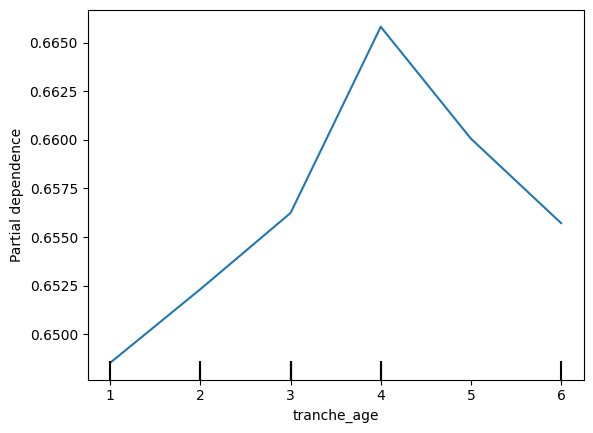

In [20]:
# PDP par sklearn
features_info = {
    # features of interest
    "features": ["tranche_age"]}

display = PartialDependenceDisplay.from_estimator(
    model,
    Xtest,
    **features_info,    
)

In [21]:
#shap 
explainer = shap.Explainer(model)
shap_values = explainer(X)

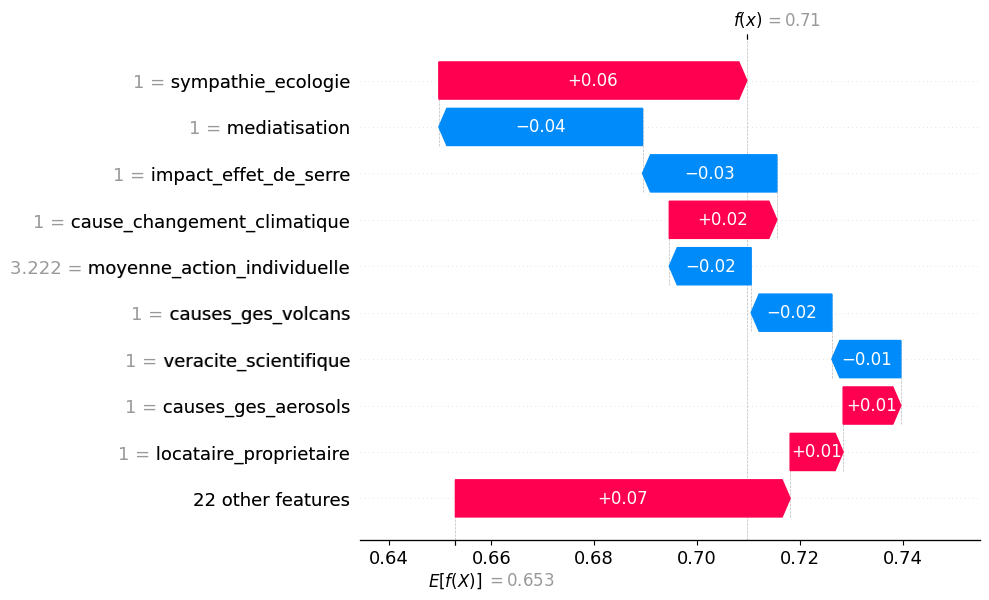

In [22]:
#affichage d'un individu
shap.plots.waterfall(shap_values[0])

### utilisation de Shapash

In [23]:
#Init Shapash
xpl = SmartExplainer(model=model,preprocessing=encoder) 

In [24]:
# Compilation de Shapash
xpl.compile(
    x=Xtest,    
    y_target = ytest,
    additional_data=df_reduit.loc[Xtest.index, :][["Vague"]],
)

In [ ]:
#Lancement de la webapp
app=xpl.run_app(port=8088)

In [26]:
app.kill()

In [27]:
#détail par variable avec Shapash
xpl.plot.contribution_plot(col="tranche_age")

In [28]:
#détail pour un individu
xpl.plot.local_plot(index=Xtest.iloc[0].name)

# Questions ?
A l'aide des méthodes d'explicabilité proposées, vous pouvez analyser et comprendre le fonctionnement du modèle.
Voici une liste de question auxquelles répondre pour montrer la compréhension du modèle.
Vous pouvez prendre des captures d'écrans de graphiques ou le code qui permet d'obtenir le graphique pour expliquer les réponses.
L'objectif est de pouvoir expliquer le fonctionnement du modèle à d'autres personnes

-Les principaux éléments qui expliquent un taux de mesure souhaitable faible ou non

-Les principaux éléments qui expliquent les gros écarts de prédictions

-Des comportements qui diffèrent entre les vagues d'enquête

-Les profils où la prédiction est à la limite

-Les anomalies 

-Des analyses par sous population

-Propositions d'améliorations pour le modèle

-Mise en avant de limites sur le dataset

-Problématiques dans la transformation de données, créations de variables

-Propositions de nouvelle transformation de données et créations de variables

-Des corrections de données ou la mise à l'écart de certaines réponses

# Application sur le sondage framaform

L'idée est de pouvoir tester les prédictions du modèle et son explicabilité sur vos résultats. 
Cela donne un atre axe de compréhension des résultats de l'explicabilité

import chardet

# Read the file
with open("../data/Sondage_TP_barometre.csv", 'rb') as f:
    result = chardet.detect(f.read())

result

In [29]:
#df_framaform = pd.read_csv("../data/Sondage_TP_barometre.tsv", sep='\t')

df_framaform = pd.read_csv("../data/Sondage_TP_barometre.csv", encoding = 'utf-8', sep='\t')

In [30]:
df_framaform.head(1)

,Vague,S1. genre,S2. âge,Région,S7b. Taille commune,s15. Diplôme,S6. Situation professionnelle,s17. Type habitat,s13. Nb membres foyer,s18. Statut locataire/propriétaire,q5. Certitude/hypothèse impact effet de serre,q9. Causes désordres du climat,q10. Causes anthropiques/naturelles du changement climatique,q11. Solutions changement climatique,q18_i1. Causes GES activités industrielles,q18_i2. Causes GES transports,q18_i3. Causes GES bâtiments,q18_i4. Causes GES agriculture,"q18_i5. Causes GES centrales de production d'électricité au gaz, charbon ou fuel",q18_i6. Causes GES traitement des déchets,q18_i7. Causes GES destruction des forêts,q18_i8. Causes GES centrales nucléaires,q18_i9. Causes GES activité volcanique,q18_i10. Causes GES bombes aérosols,s22. Mode de transport,s24. Echiquier politique,s25. Sympathie mouvements écologistes,s11. Désordre climatique subi,q23. Véracité scientifique,q14. Médiatisation changement climatique,q8. Conséquences changement climatique,q16. Optimisme limitation changement climatique,q20_i1. Action individuelle Tri déchets,q20_i2. Actin individuelle Eteindre appareils en veille,q20_i3. Actin individuelle Transports en commun,q20_i4. Actin individuelle Baisse température logement,q20_i5. Actin individuelle Acheter légumes de saison,q20_i6. Actin individuelle Limiter consommation viande,q20_i7. Actin individuelle Se déplacer en vélo ou à pied,q20_i8. Actin individuelle Covoiturage ou de l'auto-partage,q20_i9. Actin individuelle Produits avec peu d'emballage,q20_i10. Action individuelle choix Ecolabels,q20_i11. Action individuelle Consommer moins,"q20_i12. Action individuelle Couper chauffage, chauffe-eau",q20_i13. Action individuelle Pas prendre l'avion pour ses loisirs,q20_i14. Action individuelle Produits locaux,q20_i15. Action individuelle Achats vêtements seconde main,q20_i16. Action individuelle Choisir pour mon épargne une banque et/ou des placements financiers qui respectent …,q21_i1. Mesures Baisse vitesse autoroute,q21_i2. Mesures Taxe transport aérien,q21_i3. Mesures Obligation rénovation,q21_i4. Mesures Compteurs communicants,q21_i5. Mesures Prix acheminement produits,q21_i6. Mesures Taxe carbone,q21_i7. Mesures EnR,q21_i8. Mesures Densifier les villes,q21_i9. Mesures Taxe véhicules émetteurs,q21_i10. Mesures Favoriser véhicules peu polluants,q21_i11. Mesures Menu restauration collective,q21_i13. Mesures Supprimer dates de péremption,q21_i14. Mesures Interdire publicité,id_user
0,TP,Un homme,25-34 ans,Aquitaine - Limousin - Poitou - Charente,Dans une ville de 20.000 à moins de 100.000 ha...,"2EME, 3EME CYCLE UNIVERSITAIRE OU GRANDES ECOLES",...exercez actuellement une profession,Une maison individuelle,1 personne,Propriétaire (y compris copropriétaire et accé...,...ou bien une certitude pour la plupart des s...,Les désordres du climat et de leurs conséquenc...,Le réchauffement de la planète est causé par l...,Il faudra modifier de façon importante nos mod...,Beaucoup,Beaucoup,Beaucoup,Beaucoup,Beaucoup,Assez,Assez,Assez,Peu,Peu,En vélo ou à pied,Très à gauche,...beaucoup de sympathie ?,"Oui, parfois",Les scientifiques qui étudient les évolutions ...,On n'en parle pas assez,Les conditions de vie deviendront extrêmement ...,"Non, certainement pas",...vous le faites déjà,...vous le faites déjà,...vous le faites déjà,...vous le faites déjà,...vous le faites déjà,...vous le faites déjà,...vous le faites déjà,...vous le faites déjà,...vous le faites déjà,...vous le faites déjà,...vous le faites déjà,...vous pourriez le faire assez facilement,...vous pourriez le faire assez facilement,...vous le faites déjà,...vous pourriez le faire assez facilement,...vous pourriez le faire assez facilement,Très souhaitable,Très souhaitable,Assez souhaitable,Assez souhaitable,Très souhaitable,Assez souhaitable,Assez souhaitable,Pas vraiment souhaitable,Très souhaitable,Très souhaitable,Très souhaitable,Assez souhaitable,Très souhaitable,xr4979


## transformation des données
Il faut reproduire les mêmes préparation, tranformations que sur le dataset initial

In [31]:
# création d'une variable sur une note moyenne des actions individuelles que le sondé est prêt à faire
notes_mapping = {
    '...vous le faites déjà': 4,
    '...vous pourriez le faire assez facilement': 3,
    '...vous pourriez le faire mais difficilement': 2,
    '...vous ne pouvez pas le faire': 1
}

def calculer_moyenne(row):
    notes = [notes_mapping[val] for val in row if val != 'No rep.']
    return sum(notes) / len(notes) if notes else 0

df_framaform_q20 = df_framaform.filter(like='q20', axis=1).replace({'nan': 'No rep.', np.nan: 'No rep.'})

colonnes_action_individuelle = df_framaform_q20.filter(like='q20')

df_framaform_q20['moyenne_action_individuelle'] = colonnes_action_individuelle.apply(calculer_moyenne, axis=1)

df_framaform_q20['moyenne_action_individuelle'].round().value_counts()

moyenne_action_individuelle
4.0    5
3.0    2
Name: count, dtype: int64

In [32]:
# création d'une variable cible sur le taux de mesures que le sondé souhaite Très ou Assez souhaitable
notes_mapping = {
    'Très souhaitable': 4,
    'Assez souhaitable': 3,
    'Pas vraiment souhaitable': 2,
    'Pas du tout souhaitable': 1
}

# Filtrer les colonnes qui commencent par "q21"
q21_columns = [col for col in df_framaform.columns if col.startswith('q21')]

df_framaform_q21 = df_framaform.filter(like='q21', axis=1).replace({'nan': 'No rep.', np.nan: 'No rep.'})

# Initialiser une nouvelle colonne dans le DataFrame pour stocker les taux
df_framaform_q21['taux_mesures_souhaitable'] = 0.0

# Parcourir les lignes et calculer le taux pour chaque individu
for index, row in df_framaform_q21.iterrows():
    total_cols_answered = sum(row[col] != "No rep." for col in q21_columns)
    if total_cols_answered > 0:
        desirable_count = sum(row[col] in ['Très souhaitable', 'Assez souhaitable'] for col in q21_columns)
        rate = desirable_count / total_cols_answered
        df_framaform_q21.at[index, 'taux_mesures_souhaitable'] = rate

In [33]:
df_framaform = pd.concat([df_framaform, df_framaform_q20[['moyenne_action_individuelle']], df_framaform_q21['taux_mesures_souhaitable']], axis=1)

In [34]:
df_framaform.rename(columns=columns_to_rename, inplace=True)

In [35]:
df_framaform_reduit = df_framaform[features].copy()

In [36]:
df_framaform_reduit.fillna("No rep.", inplace=True)

In [37]:
df_framaform_reduit.loc[df_framaform_reduit['cause_changement_climatique'] == 'Le réchauffement de la planète est causé par les activités humaines', 'cause_changement_climatique'] = 'activites_humaines'
df_framaform_reduit.loc[df_framaform_reduit['cause_changement_climatique'] == "Il s'agit uniquement d'un phénomène naturel qui a toujours existé", 'cause_changement_climatique'] = 'phenomene_naturel'

df_framaform_reduit.loc[df_framaform_reduit['impact_effet_de_serre'] == '...ou bien une certitude pour la plupart des scientifiques ?', 'impact_effet_de_serre'] = 'certitude_scientifique'
df_framaform_reduit.loc[df_framaform_reduit['impact_effet_de_serre'] == "...une hypothèse sur laquelle les scientifiques ne sont pas tous d'accord ?", 'impact_effet_de_serre'] = 'hypothese_non_certaine'

df_framaform_reduit.loc[df_framaform_reduit['sympathie_ecologie'] == '...assez de sympathie ?', 'sympathie_ecologie'] = 'assez'
df_framaform_reduit.loc[df_framaform_reduit['sympathie_ecologie'] == "...peu de sympathie ?", 'sympathie_ecologie'] = 'peu'
df_framaform_reduit.loc[df_framaform_reduit['sympathie_ecologie'] == "...beaucoup de sympathie ?", 'sympathie_ecologie'] = 'beaucoup'
df_framaform_reduit.loc[df_framaform_reduit['sympathie_ecologie'] == "...pas de sympathie ?", 'sympathie_ecologie'] = 'pas'

df_framaform_reduit.loc[df_framaform_reduit['cause_desordre'].str.contains('Les désordres du climat'), 'cause_desordre'] = 'certitudes_causes'
df_framaform_reduit.loc[df_framaform_reduit['cause_desordre'].str.contains("Aujourd'hui, personne ne peut dire avec certitude les vraies raisons des désordres du climat"), 'cause_desordre'] = 'pas_certitude'

df_framaform_reduit.loc[df_framaform_reduit['veracite_scientifique'].str.contains('évaluent correctement les risques du changement climatique'), 'veracite_scientifique'] = 'evalue_correctement'
df_framaform_reduit.loc[df_framaform_reduit['veracite_scientifique'] == "Les scientifiques qui étudient les évolutions du climat exagèrent les risques du changement climatique", 'veracite_scientifique'] = 'scientifique_exagere'

# Cette variable est la cible du modèle
df_framaform_reduit.loc[df_framaform_reduit['solutions'] == 'Il faudra modifier de façon importante nos modes de vie pour limiter le changement climatique', 'solutions'] = 'changer'
df_framaform_reduit.loc[df_framaform_reduit['solutions'].str.contains("le changement climatique est inévitable") , 'solutions'] = 'inevitable'
df_framaform_reduit.loc[df_framaform_reduit['solutions'] == "C'est aux Etats de rechercher un accord au niveau mondial pour limiter le changement climatique", 'solutions'] = 'entre_etats'
df_framaform_reduit.loc[df_framaform_reduit['solutions'] == "Le progrès technique permettra de trouver des solutions pour limiter le changement climatique", 'solutions'] = 'progres'

In [38]:
df_framaform_reduit.head()

,Vague,genre,tranche_age,region,taille_commune,situation_pro,impact_effet_de_serre,cause_desordre,cause_changement_climatique,solutions,causes_ges_industries,causes_ges_transports,causes_ges_batiments,causes_ges_agriculture,causes_ges_energie,causes_ges_forets,causes_ges_nucleaires,causes_ges_volcans,causes_ges_aerosols,nb_membres_foyer,diplome,type_habitat,locataire_proprietaire,mode_transport,echiquier_politiques,sympathie_ecologie,changement_subi,veracite_scientifique,mediatisation,futures_consequences,limitation_changement,moyenne_action_individuelle,taux_mesures_souhaitable
0,TP,Un homme,25-34 ans,Aquitaine - Limousin - Poitou - Charente,Dans une ville de 20.000 à moins de 100.000 ha...,...exercez actuellement une profession,certitude_scientifique,certitudes_causes,activites_humaines,changer,Beaucoup,Beaucoup,Beaucoup,Beaucoup,Beaucoup,Assez,Assez,Peu,Peu,1 personne,"2EME, 3EME CYCLE UNIVERSITAIRE OU GRANDES ECOLES",Une maison individuelle,Propriétaire (y compris copropriétaire et accé...,En vélo ou à pied,Très à gauche,beaucoup,"Oui, parfois",evalue_correctement,On n'en parle pas assez,Les conditions de vie deviendront extrêmement ...,"Non, certainement pas",3.7500,0.923077
1,TP,Un homme,25-34 ans,Ile de France,Dans une ville de 20.000 à moins de 100.000 ha...,...exercez actuellement une profession,certitude_scientifique,certitudes_causes,activites_humaines,entre_etats,Beaucoup,Assez,Beaucoup,Beaucoup,Beaucoup,Beaucoup,Assez,Assez,Beaucoup,3 personnes,"2EME, 3EME CYCLE UNIVERSITAIRE OU GRANDES ECOLES",Un appartement,Locataire,En transports en commun urbains (dont métro),No rep.,beaucoup,"Non, rarement",evalue_correctement,On n'en parle pas assez,Les conditions de vie deviendront extrêmement ...,"Non, certainement pas",3.0000,0.846154
2,TP,Une femme,35-49 ans,Centre,Dans une agglomération de 100.000 habitants et...,...exercez actuellement une profession,certitude_scientifique,certitudes_causes,activites_humaines,changer,Beaucoup,Beaucoup,Beaucoup,Assez,Beaucoup,Assez,Peu,Assez,Beaucoup,4 personnes et +,"2EME, 3EME CYCLE UNIVERSITAIRE OU GRANDES ECOLES",Une maison individuelle,Propriétaire (y compris copropriétaire et accé...,En voiture (même si vous n'êtes pas le conduct...,Au centre,assez,"Oui, parfois",evalue_correctement,On en parle suffisamment,Les conditions de vie deviendront extrêmement ...,"Non, probablement pas",3.5625,0.846154
3,TP,Un homme,50-64 ans,Pays de la Loire,Dans une ville de 2000 à moins de 20.000 habit...,...êtes retraité,certitude_scientifique,certitudes_causes,activites_humaines,changer,Beaucoup,Beaucoup,Assez,Beaucoup,Beaucoup,Beaucoup,Peu,Beaucoup,Beaucoup,2 personnes,"BACCALAUREAT GENERAL, TECHNOLOGIQUE OU PROFESS...",Une maison individuelle,Propriétaire (y compris copropriétaire et accé...,En voiture (même si vous n'êtes pas le conduct...,Au centre,assez,"Oui, parfois",evalue_correctement,On en parle suffisamment,Les conditions de vie deviendront extrêmement ...,"Non, probablement pas",3.5625,0.923077
4,TP,Un homme,25-34 ans,Aquitaine - Limousin - Poitou - Charente,Dans une agglomération de 100.000 habitants et...,...exercez actuellement une profession,certitude_scientifique,certitudes_causes,activites_humaines,changer,Beaucoup,Beaucoup,Beaucoup,Beaucoup,Beaucoup,Beaucoup,Peu,Peu,Assez,2 personnes,"2EME, 3EME CYCLE UNIVERSITAIRE OU GRANDES ECOLES",Un appartement,Locataire,En train,A gauche,assez,"Non, jamais",evalue_correctement,On n'en parle pas assez,Les conditions de vie deviendront extrêmement ...,"Non, certainement pas",3.6250,1.000000


In [39]:
y_framaform = df_framaform_reduit["taux_mesures_souhaitable"]
X_framaform = df_framaform_reduit.drop(["taux_mesures_souhaitable","Vague"], axis=1)

In [40]:
X_framaform=encoder.transform(X_framaform)

In [41]:
prediction_framaform = model.predict(X_framaform)

mean_squared_error(y_framaform, prediction_framaform)

0.019084800792122325

In [42]:
xpl_framaform = SmartExplainer(model=model,preprocessing=encoder) 

In [43]:
#Si pas assez de données framaform, concat avec Xtest
X_frama = pd.concat([X_framaform, Xtest.head(1000)])
y_frama = pd.concat([y_framaform, ytest.head(1000)])




In [44]:
xpl_framaform.compile(
    x=X_frama,    
    y_target = y_frama,
    additional_data=pd.concat([df_framaform[["Vague","id_user"]],df_reduit.loc[Xtest.head(1000).index, :][["Vague"]]]),
)

In [45]:
X_framaform.head()

,genre,tranche_age,region,taille_commune,situation_pro,impact_effet_de_serre,cause_desordre,cause_changement_climatique,solutions,causes_ges_industries,causes_ges_transports,causes_ges_batiments,causes_ges_agriculture,causes_ges_energie,causes_ges_forets,causes_ges_nucleaires,causes_ges_volcans,causes_ges_aerosols,nb_membres_foyer,diplome,type_habitat,locataire_proprietaire,mode_transport,echiquier_politiques,sympathie_ecologie,changement_subi,veracite_scientifique,mediatisation,futures_consequences,limitation_changement,moyenne_action_individuelle
0,2.0,1,9,2,1,3,1,1,1,2,1,2,4,1,3,3,1,3,4,4,2,2,3,5,1,4,2,3,1,5,3.7500
1,2.0,1,5,2,1,3,1,1,3,2,2,2,4,1,1,3,2,1,3,4,1,1,4,1,1,2,2,3,1,5,3.0000
2,1.0,2,12,1,1,3,1,1,1,2,1,2,1,1,3,2,2,1,2,4,2,2,1,2,2,4,2,2,1,2,3.5625
3,2.0,3,13,4,3,3,1,1,1,2,1,1,4,1,1,2,3,1,1,5,2,2,1,2,2,4,2,2,1,2,3.5625
4,2.0,1,9,1,1,3,1,1,1,2,1,2,4,1,1,2,1,2,1,4,1,1,5,6,2,3,2,3,1,5,3.6250


In [ ]:
app_framaform=xpl_framaform.run_app(port=8078)

In [47]:
xpl_framaform.plot.compare_plot(index=[df_framaform_reduit.index[0], df_framaform_reduit.index[4]])